In [1]:
# Calcula la correlación contra ENSO y otros índices climáticos.

import os

import matplotlib

import numpy as np
import pandas as pd

from scipy import stats

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cargamos la información.

# Rutas de archivos.
path_i = "../data/Indices/"
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

df_pre = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df_pre.index = pd.to_datetime( df_pre.index )

dates = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año")
date_i = dates.copy()
date_i["Cuenca - Onset"] = pd.to_datetime( date_i["Cuenca - Onset"] )
date_i["Cuenca - Withdrawal"] = pd.to_datetime( date_i["Cuenca - Withdrawal"] )
# Se convierten las fechas a días julianos.
for i in [0, 1]:
    dates.iloc[:, i] = dates.iloc[:, i].apply(
        lambda x: pd.to_datetime(x) ).apply(lambda x: x.dayofyear)
dates.iloc[:, 2] = dates.iloc[:, 2].apply(lambda x: x[:-5]).astype(int)

df_pre = df_pre[df_pre.index.month.isin(range(6, 9))]
#dates["Pre"] = None
dates["Pre"] = df_pre.groupby(df_pre.index.year).sum().loc[:2020]

cols = ["Año"] + [i for i in range(1, 13)]
index = []
index_y = []
label = []
l = []

#label.append("BEST")
#l.append(0)
#index.append( pd.read_table( path_i + "BEST_1M", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 0, skipfooter = 0 ).loc[1981:2020] )
#label.append("BEST")
#l.append(0)
#b = pd.read_table( path_i + "BEST_3M", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 0, skipfooter = 0 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("BEST")
#l.append(0)
#b = pd.read_table( path_i + "BEST_5M", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 0, skipfooter = 0 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("MEIV")
#l.append(0)
#b = pd.read_table( path_i + "MEIV", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 1, skipfooter = 4 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("AMO")
#l.append(0)
#b = pd.read_table( path_i + "AMO_smooth", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 1, skipfooter = 4 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("AMO")
#l.append(0)
#b = pd.read_table( path_i + "AMO_unsmooth", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 1, skipfooter = 4 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("PDO")
#l.append(0)
#b = pd.read_table( path_i + "PDO", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 2, skipfooter = 1 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("OLR")
#b = pd.read_table( path_i + "OLR", sep = '\s+',
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 112, skipfooter = 2, na_values = -999.9 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("SOI")
#l.append(0)
#b = pd.read_table( path_i + "SOI", sep = "\s+",
#    engine = "python", names = cols, index_col = 0,
#    skiprows = 88, skipfooter = 10 ).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))

#label.append("CLLJ")
#l.append(0)
#b = pd.read_csv( path_d + "CLLJ_index.csv",
#    index_col = 0).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
#label.append("PACIFIC")
#l.append(0)
#b = pd.read_csv( path_d + "Pacific_index.csv",
#    index_col = 0).loc[1981:2020]
#index.append(b)
#index_y.append(b.mean(axis = 1))
label.append("CLLJ")
l.append(0)
b = pd.read_csv( path_d + "CLLJ_wind_index.csv",
    index_col = 0).loc[1981:2020]
index.append(b)
index_y.append(b.mean(axis = 1))

colsst = ["Año", "Mes", "NINO1+2", "NINO1+2_ANOM", "NINO3", "NINO3_ANOM",
    "NINO4", "NINO4_ANOM", "NINO3.4", "NINO3.4_ANOM"]
a = pd.read_table( path_i + "SST", sep = "\s+",
    engine = "python", names = colsst, index_col = [0, 1],
    skiprows = 1, skipfooter = 4 ).loc[1981:2020]

# NINO1+2
#label.append("NINO1+2")
#l.append(1)
#b = a.iloc[:, [1]].reset_index().pivot( columns = "Mes",
#    index = "Año" ).droplevel( level = 0, axis= 1 )
#index.append(b)
#index_y.append(b.mean(axis = 1))
# NINO3
#label.append("NINO3")
#l.append(1)
#b = a.iloc[:, [3]].reset_index().pivot( columns = "Mes",
#    index = "Año" ).droplevel( level = 0, axis= 1 )
#index.append(b)
#index_y.append(b.mean(axis = 1))
# NINO4
label.append("NINO4")
l.append(1)
b = a.iloc[:, [5]].reset_index().pivot( columns = "Mes",
    index = "Año" ).droplevel( level = 0, axis= 1 )
index.append(b)
index_y.append(b.mean(axis = 1))
# NINO3.4
#label.append("NINO3.4")
#l.append(1)
#b = a.iloc[:, [7]].reset_index().pivot( columns = "Mes",
#    index = "Año" ).droplevel( level = 0, axis= 1 )
#index.append(b)
#index_y.append(b.mean(axis = 1))


# Correlation boostrapping.

def pcorr(x, y, axis):
    if x.ndim == 1: 
        return stats.pearsonr(x, y)[0]
    else:
        n = y.shape[0]
        statistic = np.empty( (n,) )
        for i in range(n): statistic[i], _ = stats.pearsonr(x[i, :], y[i, :])
        return statistic

In [3]:
# Precipitación dentro de la temporada de lluvias.

for j in dates.index:
    year = df_pre[ df_pre.index.year.isin( [j] ) ]

    # Precipitación entre onset y withdrawal.
    for i in year.iterrows():
        if ( ( i[0] < date_i.loc[j, "Cuenca - Onset"] )
            or ( i[0] > date_i.loc[j, "Cuenca - Withdrawal"] ) ): 
            year.loc[ i[0] ] = 0

    dates.loc[j, "Pre"] = year.sum()[0]

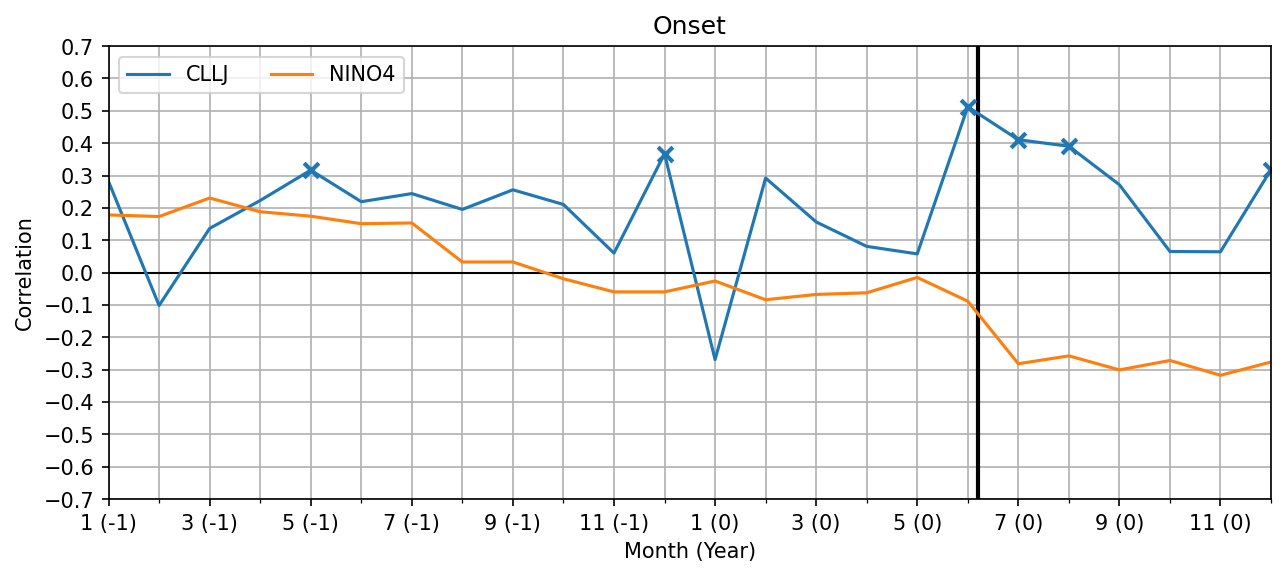

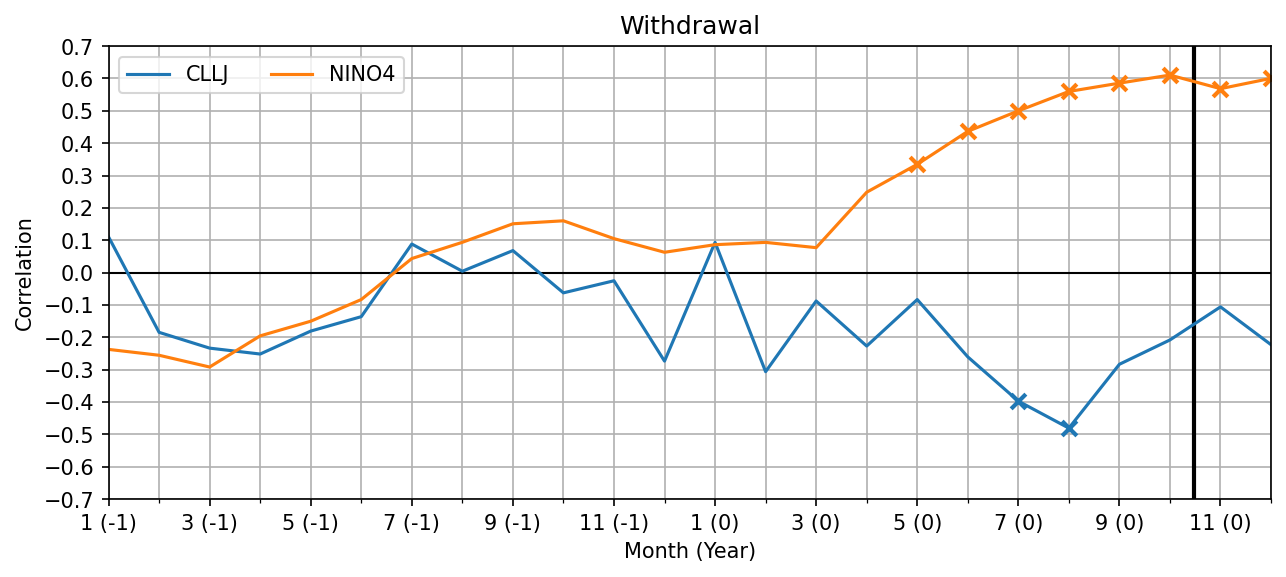

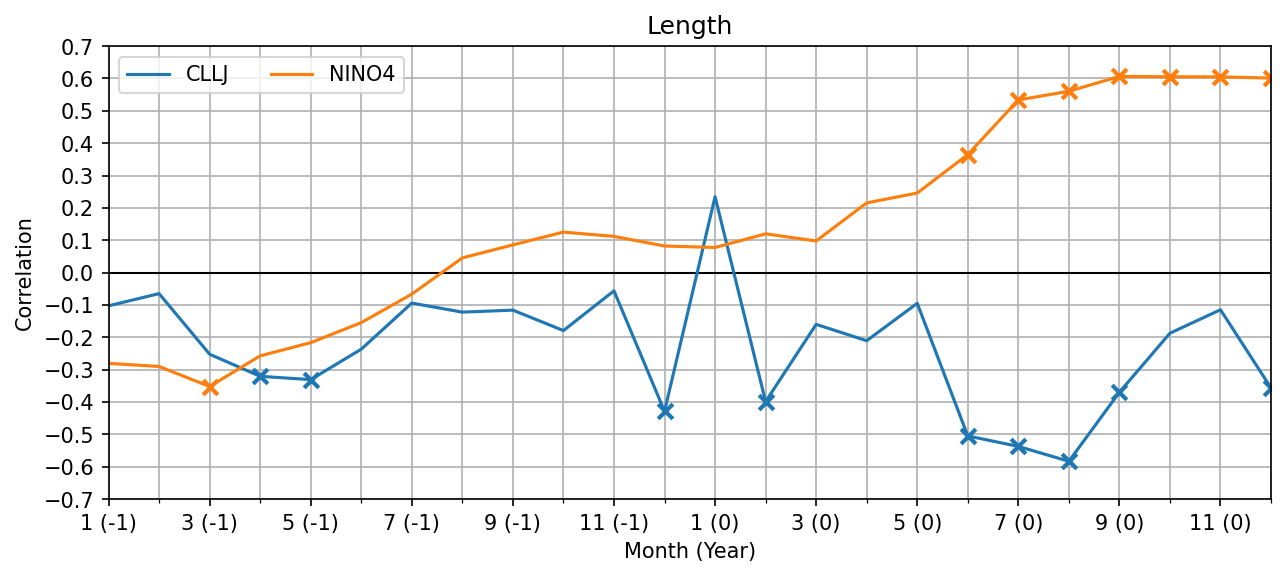

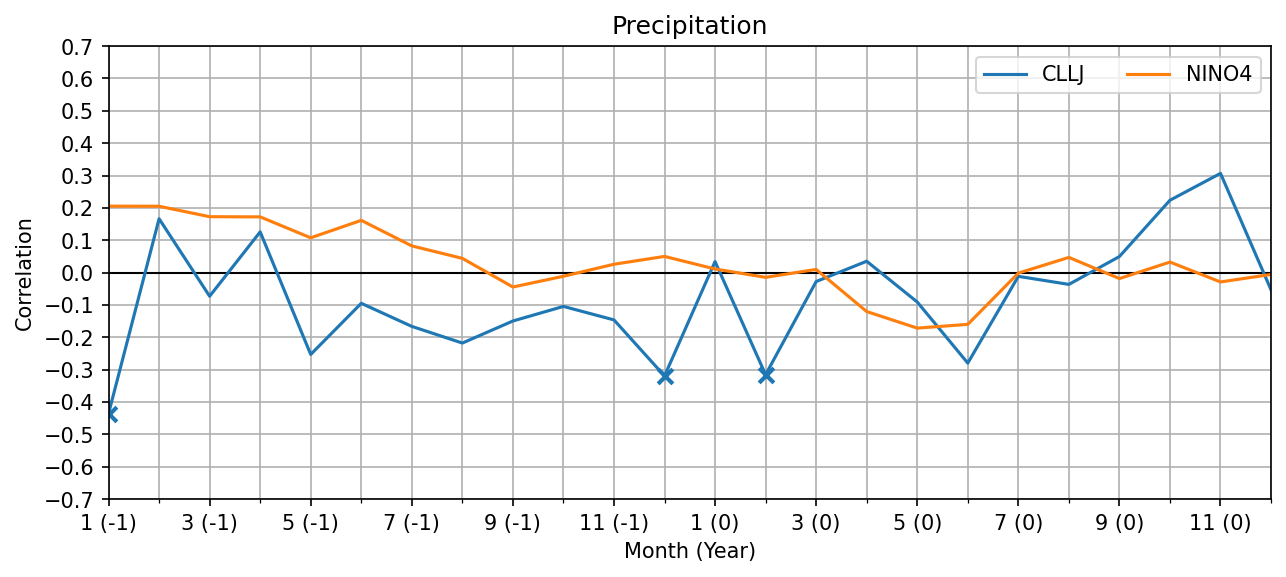

In [4]:
# Correlaciones

# Confianza
a = 0.05

cols = ["Year", "Month", "Correlation", "Significant"]
mean = [6.200, 10.484, 20, 20]
color = [ "tab:" + x for x in [ "blue", "orange", "green", "red", "purple",
    "brown", "pink", "gray", "olive", "cyan" ] ]
title = ["Onset", "Withdrawal", "Length", "Precipitation"]

fig = [None] * 4
ax = [None] * 4

legend_1 = ["_"] * 2
legend_2 = ["_"] * 2
legend_3 = ["_"] * 2
legend_4 = ["_"] * 2

for i in range(0, 4):

    fig[i], ax[i] = plt.subplots()
    fig[i].set_facecolor("w")
    fig[i].set_size_inches(10, 4)
    fig[i].set_dpi(150) 

    ax[i].set_title(title[i])
    ax[i].set_xlim(-11, 12)
    ax[i].set_ylim(-0.7, 0.7)
    ax[i].set_ylabel(f"Correlation")
    ax[i].set_xlabel("Month (Year)")
    ax[i].set_yticks(np.arange(-0.7, 0.8, 0.1))
    ax[i].set_xticks(np.arange(-11, 13, 2.0))
    ax[i].set_xticks(np.arange(-11, 13, 1.0) , minor = True )
    ax[i].set_xticklabels( [f"{x} (-1)" for x in range(1, 13, 2)] 
        + [f"{x} (0)"  for x in range(1, 13, 2)] )
    ax[i].grid(which = "both")

    ax[i].plot( (-12, 12), (0, 0), color = "k", linewidth = 1 )
    ax[i].plot( [mean[i]] * 2, (-0.7, 0.7), color = "k", linewidth = 2 )

for m in range( len(index) ):

    legend_1.append(label[m])
    legend_2.append(label[m])
    legend_3.append(label[m])
    legend_4.append(label[m])

    for i in range(0, 4):
        df = pd.DataFrame(columns = cols)

        for k in range(0, 2):
            for j in range(0, 12):

                row = [-k, j + 1 - k * 12]
                corr, _ = stats.pearsonr(
                    index[m].shift(k).iloc[k:, j], dates.iloc[k + l[m]:, i] )
                int = stats.bootstrap( [
                    index[m].shift(k).iloc[k:, j], dates.iloc[k + l[m]:, i] ],
                    pcorr, confidence_level = 0.95, method = "basic" 
                    ).confidence_interval

                if ( corr <= int[0] ) or ( corr >= int[1] ): sig = True
                else: sig = False

                row += [corr, sig]
                df = pd.concat([df, pd.DataFrame([row], columns = cols)])

        df = df.sort_values("Month")

        ax[i].plot( df["Month"], df["Correlation"], color = color[m] )

        for j in df.itertuples():
            if j[4]:
                ax[i].scatter( j[2], j[3], marker = "x", color = color[m],
                    linewidth = 2, s = 50, zorder = 2 )
                if   i == 0: legend_1.append("_")
                elif i == 1: legend_2.append("_")
                elif i == 2: legend_3.append("_")
                else       : legend_4.append("_")
        
        if   i == 0: ax[i].legend(legend_1, ncol = 2)
        elif i == 1: ax[i].legend(legend_2, ncol = 2)
        elif i == 2: ax[i].legend(legend_3, ncol = 2)
        else       : ax[i].legend(legend_4, ncol = 2)

In [5]:
for i in range(len(dates.columns)):
    dates.iloc[:, i] = stats.zscore(dates.iloc[:, i])

dates.head()

,Cuenca - Onset,Cuenca - Withdrawal,Cuenca - Length,Pre
Año,,,,
1981,-0.818015,1.423297,1.514631,0.826403
1982,1.027399,0.346721,-0.400932,-2.301254
1983,1.098376,-1.046495,-1.425535,-0.823708
1984,-0.250196,-1.426463,-0.846411,1.446267
1985,-1.953654,-0.286559,1.024603,0.840454


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


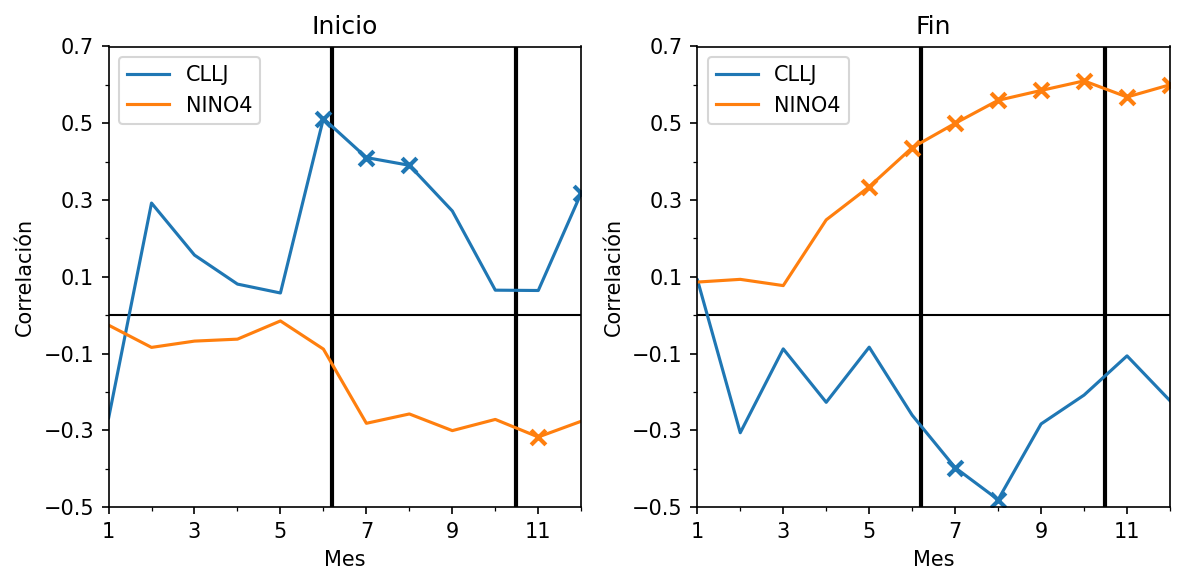

In [6]:
# Correlaciones

# Confianza
a = 0.05

cols = ["Year", "Month", "Correlation", "Significant"]
mean = [6.200, 10.484, 20]
color = [ "tab:" + x for x in [ "blue", "orange", "green", "red", "purple",
    "brown", "pink", "gray", "olive", "cyan" ] ]
title = ["Inicio", "Fin"]

fig = [None] * 2
ax = [None] * 2

legend_1 = ["_"] * 3
legend_2 = ["_"] * 3

fig, ax = plt.subplots(1, 2)
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

for i in range(0, 2):

    ax[i].set_title(title[i])
    ax[i].set_xlim(1, 12)
    ax[i].set_ylim(-0.5, 0.7)
    ax[i].set_ylabel(f"Correlación")
    ax[i].set_xlabel("Mes")
    ax[i].set_yticks(np.arange(-0.5, 0.9, 0.2))
    ax[i].set_yticks(np.arange(-0.5, 0.7, 0.1), minor = True)
    ax[i].set_xticks(np.arange(1, 13, 2.0))
    ax[i].set_xticks(np.arange(1, 13, 1.0) , minor = True )
    ax[i].set_xticklabels( [f"{x}"  for x in range(1, 13, 2)] )
    #ax[i].grid(which = "both")

    ax[i].plot( (-12, 12), (0, 0), color = "k", linewidth = 1 )
    ax[i].plot( [mean[0]] * 2, (-0.7, 0.7), color = "k", linewidth = 2 )
    ax[i].plot( [mean[1]] * 2, (-0.7, 0.7), color = "k", linewidth = 2 )

for m in range( len(index) ):

    legend_1.append(label[m])
    legend_2.append(label[m])

    for i in range(0, 2):
        df = pd.DataFrame(columns = cols)

        for k in range(0, 2):
            for j in range(0, 12):

                row = [-k, j + 1 - k * 12]
                corr, _ = stats.pearsonr(
                    index[m].shift(k).iloc[k:, j], dates.iloc[k + l[m]:, i] )
                int = stats.bootstrap( [
                    index[m].shift(k).iloc[k:, j], dates.iloc[k + l[m]:, i] ],
                    pcorr, confidence_level = 0.95, method = "basic" 
                    ).confidence_interval
                if ( corr <= int[0] ) or ( corr >= int[1] ): sig = True
                else: sig = False

                row += [corr, sig]
                df = pd.concat([df, pd.DataFrame([row], columns = cols)])

        df = df.sort_values("Month")

        ax[i].plot( df["Month"], df["Correlation"], color = color[m] )

        for j in df.itertuples():
            if j[4]:
                ax[i].scatter( j[2], j[3], marker = "x", color = color[m],
                    linewidth = 2, s = 50, zorder = 2 )
                if   i == 0: legend_1.append("_")
                else       : legend_2.append("_")
        
        if   i == 0: ax[i].legend(legend_1, ncol = 1)
        else       : ax[i].legend(legend_2, ncol = 1)

# Guardamos el archivo.
#print(df)
df.to_csv(path_d + "Correlacion_ENSO.csv")
index[0].to_csv(path_d + "index_CLLJ.csv")
index[1].to_csv(path_d + "index_ENSO.csv")

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig (path_r + "interannual.eps", bbox_inches = "tight" )

In [17]:
# Se prueba la normalidad de las series de tiempo.

from scipy import stats

print( stats.normaltest( dates    ).pvalue )
print( stats.normaltest( index[0] ).pvalue )
print( stats.normaltest( index[1] ).pvalue )

[0.11570387 0.65273206 0.80158205 0.68296452]
[0.0153659  0.9742231  0.30412485 0.45702523 0.4089352  0.52098377
 0.44132493 0.17664481 0.64986566 0.09152269 0.0027126  0.13912188]
[0.3537419  0.33321811 0.50483462 0.41806038 0.41074612 0.58278422
 0.65926269 0.25964462 0.4320638  0.3240766  0.61601901 0.27316555]


In [20]:
# Correlaciones

# Confianza
a = 0.05

cols = ["Year", "Correlation", "Significant"]
mean = [6.200, 10.484, 20]
color = [ "tab:" + x for x in [ "blue", "orange", "green", "red", "purple",
    "brown", "pink", "gray", "olive", "cyan" ] ]
title = ["Onset", "Withdrawal", "Length"]

legend_1 = ["_"] * 2
legend_2 = ["_"] * 2
legend_3 = ["_"] * 2

names = ["Onset", "Withdrawal", "Length"]

for m in range( len(index) ):
    print(f"\nÍndice {label[m]}")

    for i in range(0, 3):
        df = pd.DataFrame(columns = cols)

        for k in range(0, 2):

            row = [-k]
            corr, _ = stats.pearsonr(
                index_y[m].shift(k).iloc[k:], dates.iloc[k + l[m]:, i] )
            int = stats.bootstrap( [
                index_y[m].shift(k).iloc[k:], dates.iloc[k + l[m]:, i] ],
                pcorr, confidence_level = 0.95, method = "basic" 
                ).confidence_interval
            if ( corr <= int[0] ) or ( corr >= int[1] ): sig = True
            else: sig = False

            row += [corr, sig]
            df = pd.concat([df, pd.DataFrame([row], columns = cols)])

        df = df.sort_values("Year")


        for j in df.itertuples():
            if j[3]:
                print(f"{names[i]}, Año {j[1]}: {j[2]:.2f}")


Índice CLLJ
Onset, Año -1: 0.33
Onset, Año 0: 0.32
Withdrawal, Año 0: -0.35
Length, Año 0: -0.45

Índice NINO4
Withdrawal, Año 0: 0.48
Length, Año 0: 0.48
